In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import random

In [4]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots'
my_data_dir = proj_dir + '/my_data'
nb_dir = proj_dir + '/notebooks'

In [5]:
cd /Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts


In [6]:
from letkf import *

In [7]:
random.seed(362512)

In [8]:
## Which vertical columns are we considering here?
which_columns = {
  'lons' : [-174.5, 45.5, 75.5, -129.5, 160.5],
  'lats' : [-29.5, -59.5, -24.5, 0.5, 40.5],
  'name' : ['South Pacific', 'Southern Ocean', 'Indian Ocean', 'Tropical Pacific', 'North Pacific'],
  'save_name' : ['south_pacific', 'southern_ocean', 'indian_ocean', 'tropical_pacific', 'north_pacific']
}

In [9]:
# Load indian ocean covariance matrix
io_cov = np.load(my_data_dir +'/indian_ocean_cov.npy')
io_cov = io_cov[:64, :64]
io_cov_sqrt = np.linalg.cholesky(io_cov)

In [10]:
# Get covariance matrix
this_cov = io_cov
this_cov_sqrt = io_cov_sqrt
num_levs = this_cov.shape[0]

In [11]:
# Get correlation matrix
io_cor = np.load(my_data_dir +'/indian_ocean_cor.npy')
io_cor = io_cor[:64, :64]
this_cor = io_cor

In [12]:
## Set observation operator
HofX = np.zeros((1, num_levs))
HofX[0, -1] = 1

In [13]:
R = HofX @ this_cov @ HofX.transpose()

In [11]:
## Get state and observation positions and localization radii
atm_p = np.load(my_data_dir+'/atm_p.npy')/1e2
pos_state = np.log(atm_p)
pos_ob = pos_state[-1]

In [36]:
## Generate synthetic observations
xt = this_cov_sqrt @ np.random.normal(size=(num_levs, 1))
y_ob = HofX @  xt

In [37]:
# Set ensemble size
ens_size = 20

In [38]:
## Generate ensemble
rnd = np.random.normal(size=(num_levs, ens_size))
x_ens = this_cov_sqrt @ rnd
P_ens = np.cov(x_ens)
C_ens = np.corrcoef(x_ens)

In [12]:
## Set observation error variance equal to background error variance
R = HofX @ P_ens @ HofX.transpose()
R_inv = np.reciprocal(R)

NameError: name 'P_ens' is not defined

In [40]:
## No localization
analysis_mean_no_loc, analysis_cov_no_loc = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 1e5), np.full_like(pos_ob, 1e5), inflate=1, use_loc=False)

In [41]:
## Calculate analysis increments
background_mean = np.mean(x_ens, 1)
true_increment = xt[:,0] - background_mean
da_increment_no_loc = analysis_mean_no_loc - background_mean
innovation = y_ob - HofX @ background_mean
enkf_increment = (P_ens[-1,:]/(2*P_ens[-1,-1])) * innovation # Note this is not a general formula!
kf_increment = (this_cov[-1,:]/(2*this_cov[-1,-1])) * innovation # Note this is not a general formula!

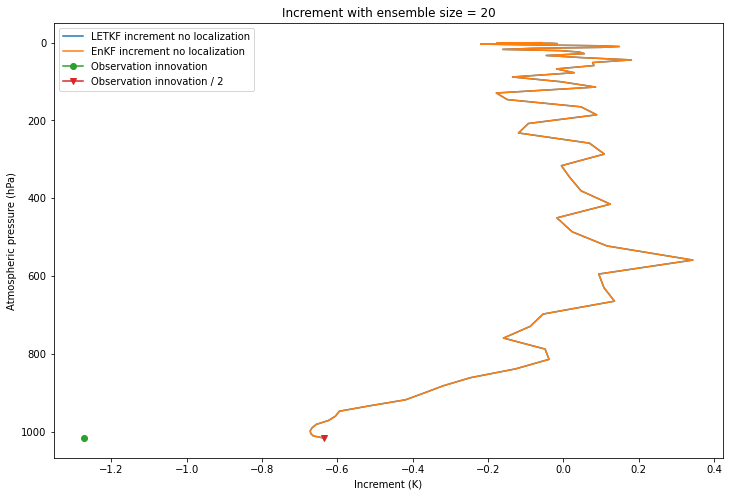

In [42]:
## Plot increment and observation
plt.plot(da_increment_no_loc, atm_p, label='LETKF increment no localization')
plt.plot(enkf_increment[0, :], atm_p, label='EnKF increment no localization')
plt.plot(innovation, atm_p[-1], marker='o', label='Observation innovation')
plt.plot(innovation/2, atm_p[-1], marker='v', label='Observation innovation / 2')
plt.legend()
plt.xlabel('Increment (K)')
plt.ylabel('Atmospheric pressure (hPa)')
plt.title('Increment with ensemble size = '+str(ens_size))
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/atm_increment_letkf_vs_enkf_ens_size_'+str(ens_size))
plt.show()

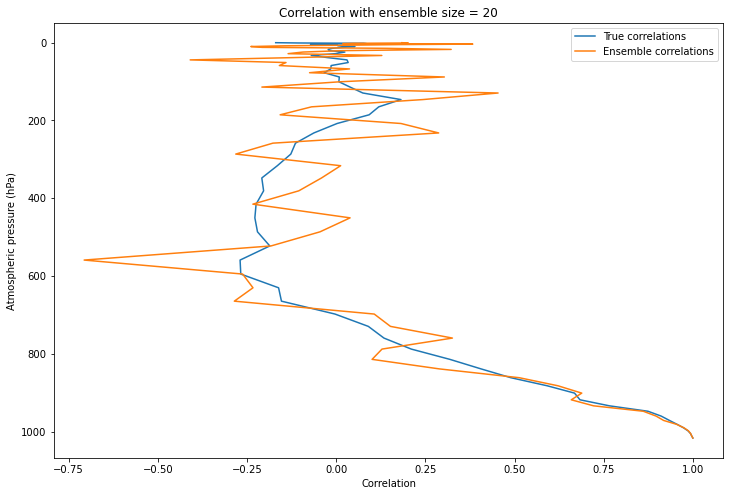

In [43]:
## Plot ensemble and true correlations
plt.plot(this_cor[-1, :], atm_p, label='True correlations')
plt.plot(C_ens[-1, :], atm_p, label='Ensemble correlations')
plt.legend()
plt.xlabel('Correlation')
plt.ylabel('Atmospheric pressure (hPa)')
plt.title('Correlation with ensemble size = '+str(ens_size))
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/atm_corr_ens_size_'+str(ens_size))
plt.show()

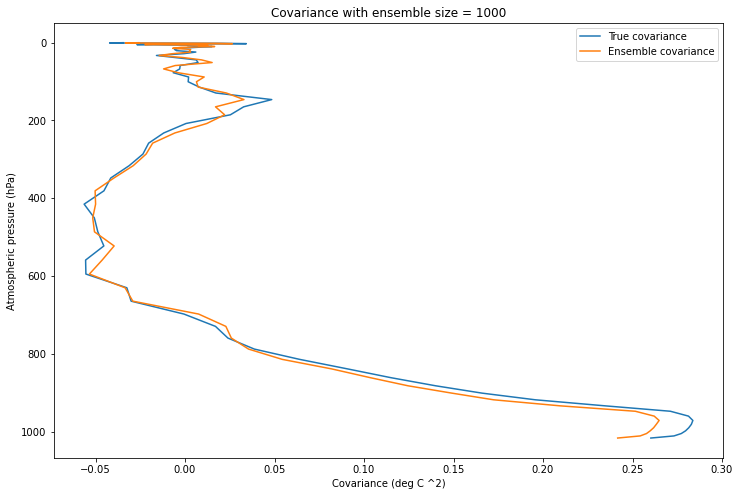

In [48]:
## Plot ensemble and true covariance
plt.plot(this_cov[-1, :], atm_p, label='True covariance')
plt.plot(P_ens[-1, :], atm_p, label='Ensemble covariance')
plt.legend()
plt.xlabel('Covariance (deg C ^2)')
plt.ylabel('Atmospheric pressure (hPa)')
plt.title('Covariance with ensemble size = '+str(ens_size))
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/atm_cov_ens_size_'+str(ens_size))
plt.show()

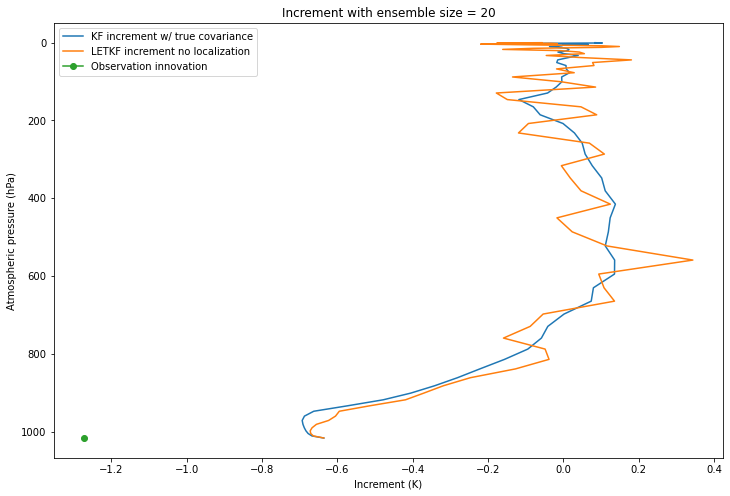

In [44]:
## Plot increment and observation
plt.plot(kf_increment[0,], atm_p, label='KF increment w/ true covariance')
plt.plot(da_increment_no_loc, atm_p, label='LETKF increment no localization')
plt.plot(innovation, atm_p[-1], marker='o', label='Observation innovation')
plt.legend()
plt.xlabel('Increment (K)')
plt.ylabel('Atmospheric pressure (hPa)')
plt.title('Increment with ensemble size = '+str(ens_size))
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/atm_increment_true_vs_letkf_no_loc'+str(ens_size))
plt.show()

In [45]:
## Get analysis mean with differen localization radii
analysis_mean_no_loc, analysis_cov_no_loc = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 1e5), np.full_like(pos_ob, 1e5), inflate=1, use_loc=False)
analysis_mean_loc1, analysis_cov_loc1 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 1), np.full_like(pos_ob, 1), inflate=1)
analysis_mean_loc2, analysis_cov_loc2 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 2), np.full_like(pos_ob, 2), inflate=1)

In [46]:
## Calculate analysis increments
background_mean = np.mean(x_ens, 1)
inc_no_loc = analysis_mean_no_loc - background_mean
inc_loc1 = analysis_mean_loc1 - background_mean
inc_loc2 = analysis_mean_loc2 - background_mean
innovation = y_ob - HofX @ background_mean
enkf_increment = (P_ens[-1,:]/(2*P_ens[-1,-1])) * innovation # Note this is not a general formula!
kf_increment = (this_cov[-1,:]/(2*this_cov[-1,-1])) * innovation # Note this is not a general formula!

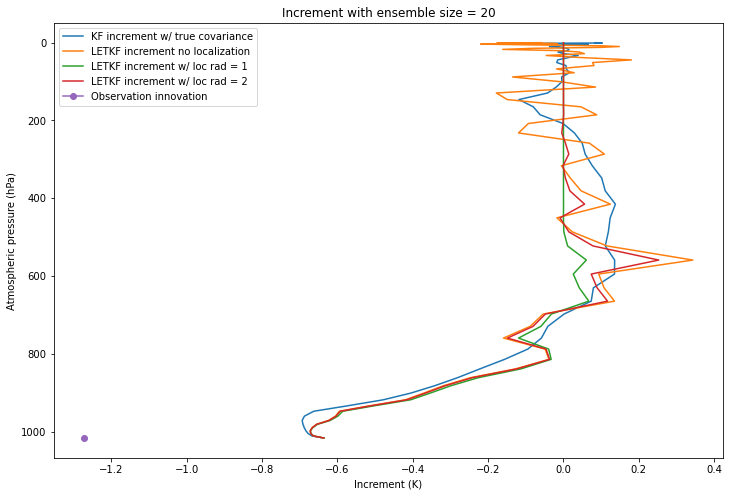

In [47]:
## Plot increment and observation
plt.plot(kf_increment[0,:], atm_p, label='KF increment w/ true covariance')
plt.plot(inc_no_loc, atm_p, label='LETKF increment no localization')
plt.plot(inc_loc1, atm_p, label='LETKF increment w/ loc rad = 1')
plt.plot(inc_loc2, atm_p, label='LETKF increment w/ loc rad = 2')
plt.plot(innovation, atm_p[-1], marker='o', label='Observation innovation')
plt.legend()
plt.xlabel('Increment (K)')
plt.ylabel('Atmospheric pressure (hPa)')
plt.title('Increment with ensemble size = '+str(ens_size))
plt.gca().invert_yaxis()

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/atm_increment_various_loc_rad_ens_size_'+str(ens_size))
plt.show()

In [33]:
pos_ob

-0.81538266

In [34]:
pos_state

array([-0.81538266,  0.16373317,  0.7028895 ,  1.0928154 ,  1.4071602 ,
        1.6760193 ,  1.9146509 ,  2.1318655 ,  2.3331919 ,  2.5223243 ,
        2.7018383 ,  2.8735933 ,  3.0389671 ,  3.1989946 ,  3.3544683 ,
        3.5059958 ,  3.6540427 ,  3.7989647 ,  3.9410276 ,  4.0804234 ,
        4.217281  ,  4.3516846 ,  4.4837213 ,  4.6134295 ,  4.7407823 ,
        4.8657002 ,  4.988062  ,  5.1077137 ,  5.224475  ,  5.3381467 ,
        5.4485164 ,  5.555366  ,  5.6584706 ,  5.7576056 ,  5.852563  ,
        5.943156  ,  6.0292263 ,  6.110647  ,  6.187329  ,  6.2592206 ,
        6.326314  ,  6.3886437 ,  6.4462852 ,  6.499353  ,  6.5479975 ,
        6.5924006 ,  6.6327686 ,  6.6693287 ,  6.70232   ,  6.7319913 ,
        6.7585926 ,  6.7823725 ,  6.803574  ,  6.8224316 ,  6.8391666 ,
        6.8539886 ,  6.867093  ,  6.8786607 ,  6.8888574 ,  6.897835  ,
        6.9057302 ,  6.9126678 ,  6.918759  ,  6.9241033 ], dtype=float32)

In [48]:
pos_ob

6.9241033

In [49]:
pos_state

array([-0.81538266,  0.16373317,  0.7028895 ,  1.0928154 ,  1.4071602 ,
        1.6760193 ,  1.9146509 ,  2.1318655 ,  2.3331919 ,  2.5223243 ,
        2.7018383 ,  2.8735933 ,  3.0389671 ,  3.1989946 ,  3.3544683 ,
        3.5059958 ,  3.6540427 ,  3.7989647 ,  3.9410276 ,  4.0804234 ,
        4.217281  ,  4.3516846 ,  4.4837213 ,  4.6134295 ,  4.7407823 ,
        4.8657002 ,  4.988062  ,  5.1077137 ,  5.224475  ,  5.3381467 ,
        5.4485164 ,  5.555366  ,  5.6584706 ,  5.7576056 ,  5.852563  ,
        5.943156  ,  6.0292263 ,  6.110647  ,  6.187329  ,  6.2592206 ,
        6.326314  ,  6.3886437 ,  6.4462852 ,  6.499353  ,  6.5479975 ,
        6.5924006 ,  6.6327686 ,  6.6693287 ,  6.70232   ,  6.7319913 ,
        6.7585926 ,  6.7823725 ,  6.803574  ,  6.8224316 ,  6.8391666 ,
        6.8539886 ,  6.867093  ,  6.8786607 ,  6.8888574 ,  6.897835  ,
        6.9057302 ,  6.9126678 ,  6.918759  ,  6.9241033 ], dtype=float32)

In [50]:
np.exp(pos_ob-2)

137.56592545256547